# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import nltk

import itertools

# Load Data

In [2]:
df_train = pd.read_csv('../data/train.tsv', sep='\t')
train_data = df_train.to_records(index=False)

df_test = pd.read_csv('../data/test.tsv', sep='\t')
test_data = df_test.to_records(index=False)

## Take a look at data

In [3]:
set([x[1] for x in train_data])

{'action', 'constituent', 'property', 'unrelated'}

## Preprocess (sentence level)

In [4]:
from sentence_level_preprocess import *

In [5]:
# remove line breaks (e.g. "elec- tron" -> "electron")
train_data = [(rm_linebreaks(t), l) for t, l in train_data]
test_data = [(rm_linebreaks(t), l) for t, l in test_data]

# lower case
train_data = [(t.lower(), l) for t, l in train_data]
test_data = [(t.lower(), l) for t, l in test_data]

# split with keys
keys = ['(', ')', '[', ']', ',', ';', ':', '/', '%', '+', '-', '−', '–', '∼','° c', '°c', '◦ c', '◦c', 'μ', 'ml']
train_data = [(split_with_keys(t, keys), l) for t, l in train_data]
test_data = [(split_with_keys(t, keys), l) for t, l in test_data]

# unify expressions for temperature (e.g. '° c' -> '<temp>')
train_data = [(c2temp_2(t), l) for t, l in train_data]
test_data = [(c2temp_2(t), l) for t, l in test_data]

## Preprocess (word level)

In [6]:
from word_level_preprocess import *

In [7]:
import re

def apply_wlpp(f, s):
    """
    Apply a word_level_preprocess function to a string.
    
    Input:
        f: word_level_preprocess function
        s: target string
    
    Output:
        string
    """
    s_ = s.split(' ')
    t = [f(x) for x in s_]
    return " ".join(t)

In [8]:
# recognize decimal as '<dec>' (e.g. '0.5' -> '<dec>')
train_data = [(apply_wlpp(put_decimal_together, t), l) for t, l in train_data]
test_data = [(apply_wlpp(put_decimal_together, t), l) for t, l in test_data]

# split with keys
keys = ['.']
train_data = [(split_with_keys(t, keys), l) for t, l in train_data]
test_data = [(split_with_keys(t, keys), l) for t, l in test_data]

# recognize integer as '<int>' (e.g. '60' -> '<int>')
train_data = [(apply_wlpp(put_int_together, t), l) for t, l in train_data]
test_data = [(apply_wlpp(put_int_together, t), l) for t, l in test_data]

# recognize ratioas '<ratio>' (e.g. '<int> : <int>' -> '<ratio>')
train_data = [(put_ratio_together(t), l) for t, l in train_data]
test_data = [(put_ratio_together(t), l) for t, l in test_data]

# unify expressions for temperature (e.g. '°c' -> '<temp>')
train_data = [(apply_wlpp(c2temp, t), l) for t, l in train_data]
test_data = [(apply_wlpp(c2temp, t), l) for t, l in test_data]

## Tokenize

In [9]:
# This separates '<int>' into ['<', 'int', '>']
"""
train_data = [(nltk.tokenize.word_tokenize(t), l) for t, l in train_data]
test_data = [(nltk.tokenize.word_tokenize(t), l) for t, l in test_data]
"""
# Word tokenization
train_data = [(t.split(' '), l) for t, l in train_data]
test_data  = [(t.split(' '), l) for t, l in test_data]

## Index words

In [10]:
from indexation import *

In [11]:
train_texts   = [x[0] for x in train_data]
train_targets = [[x[1]] for x in train_data]

test_texts   = [x[0] for x in test_data]
test_targets = [[x[1]] for x in test_data]

In [12]:
print(re.fullmatch(r"[a-z]+[0-9]+(\.[0-9]+)?", 'vc500'))

<re.Match object; span=(0, 5), match='vc500'>


In [13]:
print(re.sub(r"([a-z]+)([0-9]+(\.[0-9]+)?)", r"\1 \2", 'vc500'))

vc 500


In [14]:
print(re.fullmatch(r"[0-9]+(\.[0-9]+)?[a-z]+", '27μm'))

None


In [15]:
print(re.sub(r"([0-9]+(\.[0-9]+)?)([a-z]+)", r"\1 \3", '24h'))

24 h


In [16]:
train_texts_id, vocab_size, _, word_type2idx = word2idx(train_texts)
train_targets_id, _, _, l2idx = word2idx(train_targets)
train_targets_id = [l[0] for l in train_targets_id]
train_data_idx = list(zip(train_texts_id, train_targets_id))

test_texts_id = [[word_type2idx[w] if w in word_type2idx.keys() else vocab_size for w in s] for s in test_texts]
test_targets_id = [l2idx[l[0]] for l in test_targets]
test_data_idx = list(zip(test_texts_id, test_targets_id))

## Featurize

In [17]:
from featurize import *

In [18]:
# use vocab_size + 1 in order to express unknown words
train_data_bow = [(bow(t, vocab_size + 1), l) for t, l in train_data_idx]
test_data_bow  = [(bow(t, vocab_size + 1), l) for t, l in test_data_idx]

## Train test (validation) split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = [t for t, l in train_data_bow]
y = [l for t, l in train_data_bow]

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [22]:
X_test = [t for t, l in test_data_bow]
y_test = [l for t, l in test_data_bow]

# Learn Classifiers

## Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
model.score(X_val, y_val)

0.861878453038674

### Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [27]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

<AxesSubplot:>

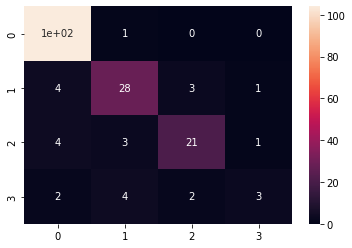

In [28]:
sns.heatmap(cm, annot=True)

<AxesSubplot:>

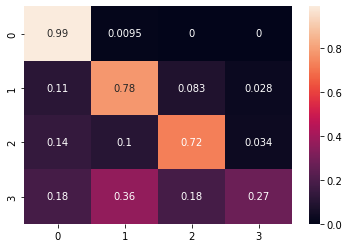

In [29]:
sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)

### Average performance

In [30]:
from sklearn.metrics import f1_score

In [31]:
num_trial = 20
f1s = []

for i in range(num_trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='micro')
    f1s.append(f1)

print("mean:", np.mean(f1s))
print("std :", np.std(f1s))

mean: 0.8403314917127072
std : 0.02912498420573967


### Test score

In [32]:
model.fit(X, y)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)

0.8546255506607929


## Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
model = RandomForestClassifier(
    n_estimators=20,
    criterion='entropy',
    max_depth=10,
    bootstrap=True,
    class_weight=None,
    max_samples=0.8
)
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_samples=0.8,
                       n_estimators=20)

In [35]:
model.score(X_val, y_val)

0.6298342541436464

### Confusion matrix

<AxesSubplot:>

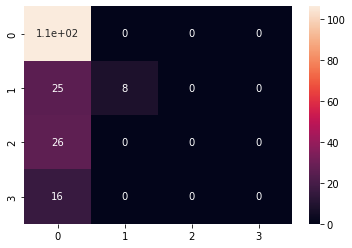

In [36]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

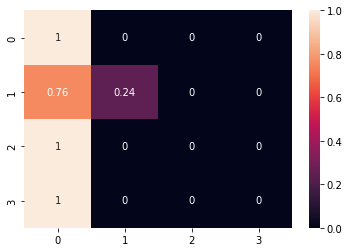

In [37]:
sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)

### Grid search

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
param_grid = {
    'n_estimators':[1, 2, 4, 8, 16, 32, 64],
    'max_depth'   :[2, 4, 8, 16, 32],
    'max_samples' :[0.2, 0.4, 0.6, 0.8]
}
gs = GridSearchCV(model, param_grid, cv=3, verbose=3)
gs.fit(X, y)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV 1/3] END max_depth=2, max_samples=0.2, n_estimators=1;, score=0.583 total time=   0.1s
[CV 2/3] END max_depth=2, max_samples=0.2, n_estimators=1;, score=0.628 total time=   0.1s
[CV 3/3] END max_depth=2, max_samples=0.2, n_estimators=1;, score=0.631 total time=   0.1s
[CV 1/3] END max_depth=2, max_samples=0.2, n_estimators=2;, score=0.642 total time=   0.1s
[CV 2/3] END max_depth=2, max_samples=0.2, n_estimators=2;, score=0.648 total time=   0.1s
[CV 3/3] END max_depth=2, max_samples=0.2, n_estimators=2;, score=0.635 total time=   0.1s
[CV 1/3] END max_depth=2, max_samples=0.2, n_estimators=4;, score=0.629 total time=   0.1s
[CV 2/3] END max_depth=2, max_samples=0.2, n_estimators=4;, score=0.631 total time=   0.1s
[CV 3/3] END max_depth=2, max_samples=0.2, n_estimators=4;, score=0.631 total time=   0.1s
[CV 1/3] END max_depth=2, max_samples=0.2, n_estimators=8;, score=0.629 total time=   0.1s
[CV 2/3] END max_depth=2, m

[CV 3/3] END max_depth=4, max_samples=0.2, n_estimators=2;, score=0.668 total time=   0.1s
[CV 1/3] END max_depth=4, max_samples=0.2, n_estimators=4;, score=0.629 total time=   0.1s
[CV 2/3] END max_depth=4, max_samples=0.2, n_estimators=4;, score=0.645 total time=   0.1s
[CV 3/3] END max_depth=4, max_samples=0.2, n_estimators=4;, score=0.631 total time=   0.2s
[CV 1/3] END max_depth=4, max_samples=0.2, n_estimators=8;, score=0.636 total time=   0.1s
[CV 2/3] END max_depth=4, max_samples=0.2, n_estimators=8;, score=0.635 total time=   0.1s
[CV 3/3] END max_depth=4, max_samples=0.2, n_estimators=8;, score=0.631 total time=   0.1s
[CV 1/3] END max_depth=4, max_samples=0.2, n_estimators=16;, score=0.629 total time=   0.2s
[CV 2/3] END max_depth=4, max_samples=0.2, n_estimators=16;, score=0.635 total time=   0.1s
[CV 3/3] END max_depth=4, max_samples=0.2, n_estimators=16;, score=0.631 total time=   0.1s
[CV 1/3] END max_depth=4, max_samples=0.2, n_estimators=32;, score=0.639 total time=   

[CV 1/3] END max_depth=8, max_samples=0.2, n_estimators=16;, score=0.679 total time=   0.1s
[CV 2/3] END max_depth=8, max_samples=0.2, n_estimators=16;, score=0.674 total time=   0.1s
[CV 3/3] END max_depth=8, max_samples=0.2, n_estimators=16;, score=0.641 total time=   0.1s
[CV 1/3] END max_depth=8, max_samples=0.2, n_estimators=32;, score=0.656 total time=   0.2s
[CV 2/3] END max_depth=8, max_samples=0.2, n_estimators=32;, score=0.638 total time=   0.2s
[CV 3/3] END max_depth=8, max_samples=0.2, n_estimators=32;, score=0.651 total time=   0.2s
[CV 1/3] END max_depth=8, max_samples=0.2, n_estimators=64;, score=0.639 total time=   0.2s
[CV 2/3] END max_depth=8, max_samples=0.2, n_estimators=64;, score=0.658 total time=   0.2s
[CV 3/3] END max_depth=8, max_samples=0.2, n_estimators=64;, score=0.645 total time=   0.2s
[CV 1/3] END max_depth=8, max_samples=0.4, n_estimators=1;, score=0.636 total time=   0.1s
[CV 2/3] END max_depth=8, max_samples=0.4, n_estimators=1;, score=0.631 total tim

[CV 2/3] END max_depth=16, max_samples=0.2, n_estimators=64;, score=0.684 total time=   0.3s
[CV 3/3] END max_depth=16, max_samples=0.2, n_estimators=64;, score=0.661 total time=   0.2s
[CV 1/3] END max_depth=16, max_samples=0.4, n_estimators=1;, score=0.649 total time=   0.1s
[CV 2/3] END max_depth=16, max_samples=0.4, n_estimators=1;, score=0.664 total time=   0.1s
[CV 3/3] END max_depth=16, max_samples=0.4, n_estimators=1;, score=0.664 total time=   0.1s
[CV 1/3] END max_depth=16, max_samples=0.4, n_estimators=2;, score=0.652 total time=   0.1s
[CV 2/3] END max_depth=16, max_samples=0.4, n_estimators=2;, score=0.664 total time=   0.1s
[CV 3/3] END max_depth=16, max_samples=0.4, n_estimators=2;, score=0.688 total time=   0.1s
[CV 1/3] END max_depth=16, max_samples=0.4, n_estimators=4;, score=0.689 total time=   0.1s
[CV 2/3] END max_depth=16, max_samples=0.4, n_estimators=4;, score=0.698 total time=   0.1s
[CV 3/3] END max_depth=16, max_samples=0.4, n_estimators=4;, score=0.674 total

[CV 3/3] END max_depth=32, max_samples=0.4, n_estimators=2;, score=0.661 total time=   0.1s
[CV 1/3] END max_depth=32, max_samples=0.4, n_estimators=4;, score=0.666 total time=   0.2s
[CV 2/3] END max_depth=32, max_samples=0.4, n_estimators=4;, score=0.701 total time=   0.1s
[CV 3/3] END max_depth=32, max_samples=0.4, n_estimators=4;, score=0.691 total time=   0.1s
[CV 1/3] END max_depth=32, max_samples=0.4, n_estimators=8;, score=0.719 total time=   0.1s
[CV 2/3] END max_depth=32, max_samples=0.4, n_estimators=8;, score=0.694 total time=   0.2s
[CV 3/3] END max_depth=32, max_samples=0.4, n_estimators=8;, score=0.704 total time=   0.1s
[CV 1/3] END max_depth=32, max_samples=0.4, n_estimators=16;, score=0.725 total time=   0.2s
[CV 2/3] END max_depth=32, max_samples=0.4, n_estimators=16;, score=0.741 total time=   0.2s
[CV 3/3] END max_depth=32, max_samples=0.4, n_estimators=16;, score=0.711 total time=   0.2s
[CV 1/3] END max_depth=32, max_samples=0.4, n_estimators=32;, score=0.709 tot

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              max_samples=0.8,
                                              n_estimators=20),
             param_grid={'max_depth': [2, 4, 8, 16, 32],
                         'max_samples': [0.2, 0.4, 0.6, 0.8],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64]},
             verbose=3)

In [40]:
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=32, max_samples=0.6,
                       n_estimators=16)

In [41]:
gs.best_score_

0.7710244732422461

### Test score

In [42]:
"""
model = gs.best_estimator_
model.fit(X, y)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
print(f1)
"""

"\nmodel = gs.best_estimator_\nmodel.fit(X, y)\ny_pred = model.predict(X_test)\nf1 = f1_score(y_test, y_pred, average='micro')\nprint(f1)\n"

## XGBoost

In [43]:
import xgboost as xgb

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [45]:
param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax', 'num_class':4}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
dval = xgb.DMatrix(X_val)
pred = bst.predict(dval)
score = accuracy_score(y_val, pred)
print(score)

0.7734806629834254


### Grid search

In [48]:
import numpy
import itertools
from sklearn.metrics import accuracy_score

class MyGridSearchCV():
    
    def __init__(self, model, param_grid, cv):
        self.m = model
        self.pg = param_grid
        self.cv = cv
        # processed
        pg_ex, pg_keys = self.expand_(self.pg)
        self.pg_ex = pg_ex
        self.pg_keys = pg_keys
        self.pg_ex_adj = self.adj_(pg_ex, pg_keys)
        # results
        self.best_param_ = None
        self.best_score_ = 0
    
    def fit(self, x, y, num_round, verbose=False):
        ds = self.cv_split_(x, y, self.cv)
        for p in self.pg_ex_adj:
            scores = []
            for dtrain, dval in ds:
                r = self.m.train(p, dtrain, num_round)
                dval_x, dval_y = dval
                pred = r.predict(dval_x)
                score = accuracy_score(dval_y, pred)
                scores.append(score)
            curr_score = sum(scores)/len(scores)
            if verbose:
                print("params:", p)
                print("accuracy:", curr_score)
            if self.best_score_ < curr_score:
                self.best_score_ = curr_score
                self.best_param_ = p
    
    def expand_(self, pg):
        keys = list(pg.keys())
        
        vals = list(pg.values())
        pg_ex = self.prod_(vals)
        
        return pg_ex, keys
    
    def prod_(self, nl):
        """
        nl: nested list
        """
        if len(nl) > 1:
            p = list(itertools.product(nl[0], self.prod_(nl[1:])))
            flattened = []
            for x in p:
                x0 = x[0] if type(x[0]) is tuple else tuple([x[0]])
                x1 = x[1] if type(x[1]) is tuple else tuple([x[1]])
                flattened.append(x0 + x1)
            return flattened
        else:
            return nl[0]
    
    def adj_(self, vals, keys):
        l = []
        for v in vals:
            d = {k:p for k, p in zip(keys, v)}
            l.append(d)
        return l
    
    def cv_split_(self, x, y, cv):
        asgn = np.random.randint(0, cv, len(x))
        ds = []
        for i in range(cv):
            # validation data
            x_val = [x[j] for j in range(len(x)) if asgn[j]==i]
            y_val = [y[j] for j in range(len(y)) if asgn[j]==i]
            dval_x = xgb.DMatrix(x_val)
            dval = (dval_x, y_val)
            # training data
            x_trn = [x[j] for j in range(len(x)) if asgn[j]!=i]
            y_trn = [y[j] for j in range(len(y)) if asgn[j]!=i]
            dtrain = xgb.DMatrix(x_trn, label=y_trn)
            # combine
            ds.append((dtrain, dval))
        return ds

In [49]:
param_grid = {
    'max_depth':[2, 4, 8, 16, 32, 64],
    'eta':[0.5, 1, 2],
    'objective':['multi:softmax'],
    'num_class':[4]
}
cv = 3
gs = MyGridSearchCV(xgb, param_grid, cv)

num_round = 10
gs.fit(X, y, num_round, verbose=True)

params: {'max_depth': 2, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.7622591341341342
params: {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.7845970970970971
params: {'max_depth': 2, 'eta': 2, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.746361986986987
params: {'max_depth': 4, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.8018956456456455
params: {'max_depth': 4, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.8107357357357357
params: {'max_depth': 4, 'eta': 2, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.7960554304304304
params: {'max_depth': 8, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.8139764764764764
params: {'max_depth': 8, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.8196602852852853
params: {'max_depth': 8, 'eta': 2, 'objective': 'multi:softmax', 'num_class': 4}
accuracy: 0.8058433433433434
param

KeyboardInterrupt: 

In [ ]:
gs.best_param_

In [ ]:
gs.best_score_

### Test score

In [ ]:
"""
dtrain = xgb.DMatrix(X, label=y)
num_round = 10
bst = xgb.train(gs.best_param_, dtrain, num_round)

dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)
f1 = f1_score(y_test, y_pred, average='micro')

print(f1)
"""

## Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import accuracy_score

In [ ]:
class NNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, seqlen, K):
        super().__init__()
        # reserve last feature for padding which is always zero
        self.emb = nn.Embedding(vocab_size + 1, emb_dim, padding_idx=vocab_size)
        self.bilstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True, bidirectional=True)
        self.key = nn.Linear(hid_dim * 2, hid_dim * 2, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.droput = nn.Dropout(p=0.1)
        self.linear = nn.Linear(seqlen, 1, bias=False)
        self.output = nn.Linear(hid_dim * 2, K, bias=False)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        """
        X: bsz x seqlen
        """
        embedded = self.emb(X) # bsz x seqlen x emb_dim
        
        feats, _ = self.bilstm(embedded) # bsz x seqlen x (hid_dim * 2)
        
        key = self.key(feats) # bsz x seqlen x (hid_dim * 2)
        query = torch.permute(feats, (0, 2, 1)) # bsz x (hid_dim * 2) x seqlen
        attn = torch.bmm(key, query) # bsz x seqlen x seqlen
        attn = self.softmax(attn) # bsz x seqlen x seqlen
        value = query # bsz x (hid_dim * 2) x seqlen
        c = torch.bmm(value, attn) # bsz x (hid_dim * 2) x seqlen
        c = self.droput(c)
        
#         h = self.linear(c) # bsz x (hid_dim * 2) x 1
        h = torch.mean(c, dim=2)
        h = torch.squeeze(h) # bsz x (hid_dim * 2)
        
        out = self.output(h) # bsz x K
        
        log_probs = self.log_softmax(out) # bsz x K
        
        return log_probs

In [ ]:
class DataLoader:
    def __init__(self, data, bsz, max_len, vocab_size):
        self.data =data
        self.bsz = bsz
        self.max_len = max_len
        self.vocab_size = vocab_size
    
    def __len__(self):
        return len(self.data)
          
    def __iter__(self):
        for i in range(0, len(self.data), self.bsz):
            if i+self.bsz < len(self.data):
                x = [d[0] + [vocab_size for i in range(self.max_len - len(d[0]))]
                    for d in self.data[i:i+self.bsz]]
                y = [d[1] for d in self.data[i:i+self.bsz]]
                yield x, y
            else:
                x = [d[0] + [vocab_size for i in range(self.max_len - len(d[0]))]
                    for d in self.data[i:]]
                y = [d[1] for d in self.data[i:]]
                yield x, y

def train_nn(self, train_data, val_data, bsz, lr, epochs, K, max_len, vocab_size):
    train_dl = DataLoader(train_data, bsz, max_len, vocab_size)
    val_dl   = DataLoader(val_data, len(val_data), max_len, vocab_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss(reduction='mean')

    best_acc = 0
    for epoch in range(epochs):
        print("epoch:", epoch)
        for x, y in train_dl:
            X = torch.LongTensor(x) # bsz x seqlen
            Y = torch.LongTensor(y) # bsz

            model.train()
            model.zero_grad()
            optimizer.zero_grad()

            log_probs = model.forward(X)
            loss = criterion(log_probs, Y)
            # print("training loss:", loss.item())
            _, pred = torch.max(log_probs, 1)
            trn_acc = accuracy_score(y, pred.detach().numpy())
            print("training accuracy:", trn_acc)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        model.eval()
        for x, y in val_dl: # loop only once
            X = torch.LongTensor(x) # bsz x seqlen
            log_probs = model.forward(X) # bsz x K
            _, pred = torch.max(log_probs, 1)
        val_acc = accuracy_score(y, pred.detach().numpy())
        print("validation accuracy:", val_acc)
        if best_acc < val_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')

    model.load_state_dict(torch.load('best_model.pt'))
    return model, best_acc

In [ ]:
emb_dim = 4
hid_dim = 3
max_len = 128
K = 4
model = NNClassifier(vocab_size, emb_dim, hid_dim, max_len, K)

In [ ]:
xt, xv, yt, yv = train_test_split(train_texts_id, train_targets_id, test_size=0.2)
dt = list(zip(xt, yt))
dv = list(zip(xv, yv))

bsz = 256
lr = 0.01
epochs = 50
model, _ = train_nn(
    model,
    dt,
    dv,
    bsz, lr, epochs, K, max_len, vocab_size
)

In [ ]:
def cv_split(x, y, cv):
    asgn = np.random.randint(0, cv, len(x))
    ds = []
    for i in range(cv):
        # validation data
        x_val = [x[j] for j in range(len(x)) if asgn[j]==i]
        y_val = [y[j] for j in range(len(y)) if asgn[j]==i]
        dval = list(zip(x_val, y_val))
        # training data
        x_trn = [x[j] for j in range(len(x)) if asgn[j]!=i]
        y_trn = [y[j] for j in range(len(y)) if asgn[j]!=i]
        dtrain = list(zip(x_trn, y_trn))
        # combine
        ds.append((dtrain, dval))
    return ds

### Cross validation

In [ ]:
cv = 3
ds = cv_split(train_texts_id, train_targets_id, cv)

emb_dim = 32
hid_dim = 16
max_len = 128
K = 4

bsz = 128
lr = 0.01
epochs = 100
acc = []
for dt, dv in ds:
    model = NNClassifier(vocab_size, emb_dim, hid_dim, max_len, K)
    model, best_acc = train_nn(
        model,
        dt,
        dv,
        bsz, lr, epochs, K, max_len, vocab_size
    )
    acc.append(best_acc)
    del model

print(sum(acc)/len(acc))